In [86]:
import torch
import torch.nn as nn
import random
from tqdm import tqdm

In [5]:
class FeedForwardMLP(nn.Module):
    
    def __init__(self, 
                 in_dims:int, 
                 hidden_dims:int, 
                 dropout:float=0.1
                ):
        
        super(FeedForwardMLP, self).__init__()
        
        self.in_dims = in_dims
        self.hidden_dims = hidden_dims
        
        self.sequence = nn.Sequential(
            nn.Linear(self.in_dims, self.hidden_dims),
            nn.ReLU(),
            nn.Linear(self.hidden_dims, self.in_dims),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.sequence(x)
        

In [6]:
x = torch.randn(3,10,25)
m = FeedForwardMLP(25, 200)
m(x).shape

torch.Size([3, 10, 25])

In [63]:
import math

class CausalSelfAttention(nn.Module):
    
    def __init__(self,
                 embedding_dims:int,
                 heads:int,
                 block_size:int,
                 dropout:float=0.1
                ):
        
        '''
        Performs multi-headed, causal self attention over input embeddings. Assumes input
        tensor of shape batch, tokens, embeddings (B, T, E) and returns a tensor of the
        same shape.
        
        ...
        
        
        Arguments
        ---------
        
        embedding_dims : int
            size of the embedding dimension
        heads : int
            number of heads in the attention block
        block_size : int
            maximum size of an input (T dimension)
        dropout : float
            amount of dropout to apply after attention. 0->1
        
        TODO's
        ------
        * not config driven
        * dropout always assumed to exist
        '''
        
        super(CausalSelfAttention, self).__init__()
        
        assert embedding_dims % heads == 0 # we can't have leftover embedding dims after splitting into heads
        
        self.heads = heads
        self.embedding_dims = embedding_dims
        self.block_size = block_size
        self.head_dims = self.embedding_dims // self.heads # head dims, D
        self.dk_sqrt = math.sqrt(self.head_dims) # normalization term for attention
        
        # (3 * E) since we need (q,k,v) each of size E
        self.qkv_projection = nn.Linear(embedding_dims, 3 * embedding_dims)
        self.attn_dropout = nn.Dropout(dropout)
        self.out_projection = nn.Linear(embedding_dims, embedding_dims)
        self.residual_dropout = nn.Dropout(dropout)
        
        # mask to apply to ensure we only look leftward when applying attention
        mask = torch.tril(torch.ones(self.block_size, self.block_size))[None,None,...]
        self.register_buffer('mask', mask)
        
    def calculate_attention(self, q, k, v):
        '''
        calculates Scaled Dot-Product Attention:
            
            Attention(Q, K, V) = softmax(QKᵀ/√dₖ)V
        
        ...
        
        
        Arguments
        ---------
        
        q : Tensor
            query tensor
        k : Tensor
            key tensor
        v : Tensor
            value tensor
        '''
        
        B, H, T, D = q.shape # Batch, Head, Token, Head Dims (assumes q,k,v all same shape)
        
        # calculate dot product similarity between queries and keys (B, H, T, D) @ (B, H, D, T) = (B, H, T, T)
        qk_similarity = q @ k.transpose(-2, -1) / self.dk_sqrt
        
        # mask tokens to the left of the current position
        masked_similarity = qk_similarity.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        
        # softmax on last dimension
        attention = torch.softmax(masked_similarity, dim=-1)
        
        # apply dropout
        attention = self.attn_dropout(attention)
        
        # apply attention to values (B, H, T, T) @ (B, H, T, D) = (B, H, T, D)
        out = attention @ v
            
        return out
        
    def forward(self, x):
        
        B, T, E = x.shape # Batch size, Tokens, Embedding Dims (B, T, E)
        
        # forward projection and split into q, k, v
        qkv = self.qkv_projection(x).split(self.embedding_dims, dim=-1)
        
        # reshape to (B, T, H, D), then swap T and H dims so it's ordered by head, not token (B, H, T, D)
        q, k, v = [c.view(B, T, self.heads, self.head_dims).transpose(1, 2) for c in qkv]
        
        # calculate attention
        attention = self.calculate_attention(q, k, v)
        
        # swap back H and T to get (B, T, H, D), then concat all heads
        attention = attention.transpose(1, 2).contiguous().view(B, T, E)
        
        # feed through outward projection
        out = self.out_projection(attention)
        
        # return with residual dropout
        return self.residual_dropout(out)

    
att = CausalSelfAttention(256, 8, 12)
x = torch.randn(3, 10, 256)
att(x).shape

torch.Size([3, 10, 256])

In [64]:
class TransformerBlock(nn.Module):
    
    def __init__(self, embedding_dims:int, heads:int, block_size:int, ff_dims:int, dropout:float =  0.1):
        
        '''
        Basic transformer block.  Applies attention followed by feed forward with residual connections.
        
        ...
        
        Arguments
        ---------
        
        embedding_dims : int
            size of the embedding dimension
        heads : int
            number of heads in the attention block
        block_size : int
            maximum size of an input (T dimension)
        ff_dims : int
            number of hidden states for the feed forward layers
        dropout : float
            amount of dropout to apply after attention. 0->1
        
        TODO's
        ------
        * not config driven
        * dropout always assumed to exist
        '''
        
        super(TransformerBlock, self).__init__()
        
        self.embedding_dims = embedding_dims
        self.heads = heads
        self.block_size = block_size
        self.ff_dims = ff_dims
        self.dropout = dropout
        
        self.attention_block = CausalSelfAttention(self.embedding_dims, self.heads, self.block_size, self.dropout)
        self.attention_norm = nn.LayerNorm(self.embedding_dims)
        self.feed_forward = FeedForwardMLP(self.embedding_dims, self.ff_dims)
        self.feed_forward_norm = nn.LayerNorm(self.embedding_dims)
        
    def forward(self, x):
        x = x + self.attention_block(self.attention_norm(x))
        x = x + self.feed_forward(self.feed_forward_norm(x))
        return x
    
tb = TransformerBlock(256, 8, 64, 1024)
x = torch.randn(3, 10, 256)
tb(x).shape

torch.Size([3, 10, 256])

In [88]:
class PositionalEmbedding(nn.Module):
    
    def __init__(self, embedding_dims:int, block_size:int):
        
        super(PositionalEmbedding, self).__init__()
        
        self.embedding_dims = embedding_dims
        self.block_size = block_size
        
        self.embedding = nn.Embedding(block_size, embedding_dims)
        
    def forward(self, x):
        
        B, T, E = x.shape # batch size, tokens, embedding dims
        
        # create range for size of this batch
        position_range = torch.arange(T).to(x.device)
        # get embeddings, then add Batch broadcasting dimension
        position_embeddings = self.embedding(position_range)[None,...]
        
        x = x + position_embeddings
        
        return x
    
pe = PositionalEmbedding(5, 64)
xx = torch.zeros(3,10,5)
pe(xx)

tensor([[[-0.1534,  0.3322, -0.0755,  1.4114, -0.3405],
         [-0.8822,  0.9989, -2.0616, -1.2288, -1.3333],
         [ 1.4288,  0.6870,  0.7173,  0.5712, -0.4433],
         [-0.1188,  0.9762,  1.4979, -0.1930,  1.6136],
         [-0.4460,  0.3376,  0.3791, -0.4095,  0.2099],
         [-0.0689,  2.3032, -2.0311, -0.9460, -1.9515],
         [-0.8834,  0.2956,  0.0699, -0.1745,  0.5956],
         [ 0.4196,  0.1325, -1.4552,  0.5631,  1.2488],
         [-1.1302,  0.9346,  0.6068,  0.4731, -1.2558],
         [-0.5613,  0.8914,  0.9575, -0.2208,  1.2251]],

        [[-0.1534,  0.3322, -0.0755,  1.4114, -0.3405],
         [-0.8822,  0.9989, -2.0616, -1.2288, -1.3333],
         [ 1.4288,  0.6870,  0.7173,  0.5712, -0.4433],
         [-0.1188,  0.9762,  1.4979, -0.1930,  1.6136],
         [-0.4460,  0.3376,  0.3791, -0.4095,  0.2099],
         [-0.0689,  2.3032, -2.0311, -0.9460, -1.9515],
         [-0.8834,  0.2956,  0.0699, -0.1745,  0.5956],
         [ 0.4196,  0.1325, -1.4552,  0.5631, 

In [77]:
class CausalTransformer(nn.Module):
    
    def __init__(self, vocab_size:int, num_layers:int, embedding_dims:int, heads:int, block_size:int, ff_dims:int, dropout:float =  0.1):
        
        '''
        A GPT style, decoder only causal transformer
        
        ...
        
        Arguments
        ---------
        
        vocab_size : int
            total number of valid tokens in the tokenizer vocabulary
        num_layers : int
            number of transformer block layers to stack for the forward pass after the embedding step
        embedding_dims : int
            size of the embedding dimension
        heads : int
            number of heads in the attention block
        block_size : int
            maximum size of an input (T dimension)
        ff_dims : int
            number of hidden states for the feed forward layers
        dropout : float
            amount of dropout to apply after attention. 0->1
        
        TODO's
        ------
        * not config driven
        * dropout always assumed to exist
        '''
        
        super(CausalTransformer, self).__init__()
        
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embedding_dims = embedding_dims
        self.heads = heads
        self.block_size = block_size
        self.ff_dims = ff_dims
        self.dropout = dropout
        
        self.token_embedding = nn.Embedding(self.vocab_size, self.embedding_dims)
        self.positional_embedding = PositionalEmbedding(self.embedding_dims, self.block_size)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(embedding_dims, heads, block_size, ff_dims, dropout) for _ in range(self.num_layers)])
        
        self.lm_head = nn.Linear(self.embedding_dims, self.vocab_size)
    
    
    def forward(self, x):
        
        tok_emb = self.token_embedding(x)
        pos_emb = self.positional_embedding(tok_emb)
        hidden_states = self.transformer_blocks(pos_emb)
        
        logits = self.lm_head(hidden_states)
        
        return logits

model = CausalTransformer(64, 8, 256, 8, 64, 1024, 0.1)
tokens = torch.tensor([[10, 15, 12, 32, 9]])
tokens.shape, model(tokens).shape

(torch.Size([1, 5]), torch.Size([1, 5, 64]))

In [78]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [79]:
chars = sorted(list(set(''.join(words)))) #lol
token_lookup = {c: i+1 for i, c in enumerate(chars)}
token_lookup['#'] = 0
token_lookup['$'] = len(chars) + 1
char_lookup = {i:c for c, i in token_lookup.items()}
TOTAL_TOKENS = len(char_lookup.keys())
print(token_lookup, TOTAL_TOKENS)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '#': 0, '$': 27} 28


In [82]:
# build the dataset

BLOCK_SIZE = max([len(w) for w in words]) + 2 # context size to give the model in order to predict the next character
print(f'Block size set to {BLOCK_SIZE}')

def build_dataset(corpus, block_size, codebook, start_padding_char="#", end_padding_char="$"):
    X, Y = [], []
    for word in corpus:
        word_len = len(word)
        end_padding_amount = block_size - (word_len + 1)
        end_padding = end_padding_char * end_padding_amount
        padded_word = f"{start_padding_char}{word}{end_padding}"
        tokenized_word = [codebook[c] for c in padded_word]
        X.append(tokenized_word[:block_size-1])
        Y.append(tokenized_word[1:])
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    
    return X, Y


random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

x_train, y_train = build_dataset(words[:n1], BLOCK_SIZE, token_lookup)
x_valid, y_valid = build_dataset(words[n1:n2], BLOCK_SIZE, token_lookup)
x_test, y_test = build_dataset(words[n2:], BLOCK_SIZE, token_lookup)

Block size set to 17
torch.Size([25626, 16]) torch.Size([25626, 16])
torch.Size([3203, 16]) torch.Size([3203, 16])
torch.Size([3204, 16]) torch.Size([3204, 16])


In [98]:
import torch.nn.functional as F

model = CausalTransformer(vocab_size=TOTAL_TOKENS, num_layers=5, embedding_dims=512, heads=16, block_size=32, ff_dims=2048)
print(sum(p.numel() for p in model.parameters()))

device = 'cuda:1'
steps = 3000
print_steps = 2000
BATCH_SIZE = 256

losses = []

optim = torch.optim.Adam(model.parameters())
pbar = tqdm(range(steps))

model.to(device)

for t in pbar:
    batch_ix = torch.randint(0, x_train.shape[0], (BATCH_SIZE,))
    batch = x_train[batch_ix].to(device)
    logits = model(batch)
    y = y_train[batch_ix].view(-1)
    
    loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.to(device))
    losses.append(loss.item())
    pbar.set_description(desc=f'average loss: {(sum(losses[-100:])/100):.2f}')

    model.zero_grad()
    loss.backward()
    optim.step()

15807004


average loss: 0.74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:32<00:00, 19.64it/s]


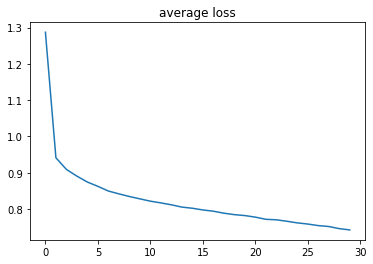

In [100]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(losses).view(-1, 100).mean(1))
plt.title("average loss");

In [101]:
model.to('cpu')
model.train(False)

# clculate training and validation loss
@torch.no_grad()
def calc_loss(x_target, y_target):
    logits = model(x_target)
    loss = F.cross_entropy(logits.view(-1, logits.shape[-1]),  y_target.view(-1))
    return loss

('train', calc_loss(x_train, y_train).item()), ('val', calc_loss(x_valid, y_valid).item())

(('train', 0.723267138004303), ('val', 0.9275473952293396))

yanine
mark
josniel
hazel
sircha
merrit
yesmina
fernando
eilany
ralj
remie
mercure
kingo
delanie
matilyn
ashitha
adaleigh
codi
ruhani
linnea


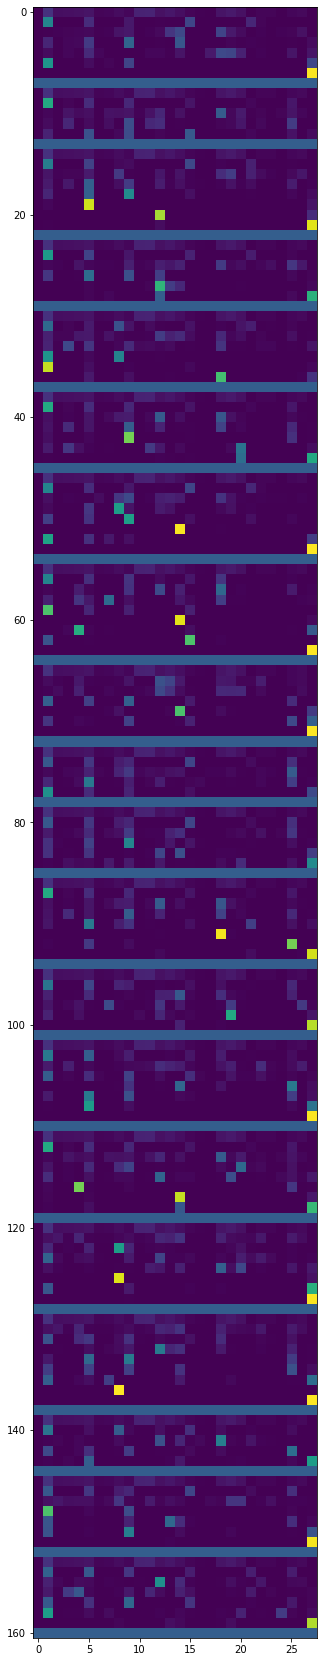

In [102]:
# sample
prob_map = []
@torch.no_grad()
def sample():
    tokens = [0] * BLOCK_SIZE
    pos = 0
    while True:
        cur_tokens = torch.tensor(tokens).unsqueeze(0)
        logits = model(cur_tokens).squeeze(0)
        probs = torch.softmax(logits[pos], dim=0)
        prob_map.append(probs.detach().numpy())
        ix = torch.multinomial(probs, num_samples=1).item()
        tokens[pos + 1] = ix
        pos += 1
        if ix == 27 or pos == BLOCK_SIZE - 1:
            break
    decoded = "".join([char_lookup[t] for t in tokens])
    return decoded.replace("#", "").replace("$", "")

for i in range(20):
    print(sample())
    prob_map.append([0.3] * len(prob_map[-1]))
    
plt.figure(figsize=(10,30))
plt.imshow(prob_map)

In [156]:
# sample
@torch.no_grad()
def p_sample(p, temp=1.0, top_k=3):
    tokens = [token_lookup[t] for t in p]
    tokens = tokens + [0] * (BLOCK_SIZE - len(tokens))
    pos = len(p)
    while True:
        cur_tokens = torch.tensor(tokens).unsqueeze(0)
        logits = model(cur_tokens)
        logits = logits[:, pos, :] / temp
        top_k_vals, _ = torch.topk(logits, top_k)
        # set any value less than the K'th value to -inf
        kth_vals = top_k_vals[:, [-1]]
        logits[logits < kth_vals] = float('-inf')
        probs = torch.softmax(logits, dim=-1)
        prob_map.append(probs.detach().numpy())
        ix = torch.multinomial(probs, num_samples=1).item()
        tokens[pos + 1] = ix
        pos += 1
        if ix == 27 or pos == BLOCK_SIZE - 1:
            break
    decoded = "".join([char_lookup[t] for t in tokens])
    return decoded.replace("#", "").replace("$", "")

for i in range(20):
    print(p_sample("#", 0.0001))
    

ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
ariana
